<a href="https://colab.research.google.com/github/NikitaSUAI/EventDetection/blob/main/BaseLine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import zipfile
import os
import pickle
import io
from pathlib import Path
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import librosa.display
from tqdm.notebook import tqdm
from IPython.display import Audio, display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.svm import SVC
from sklearn.metrics import classification_report

import torchaudio.transforms
import torchaudio.functional
import torchaudio
import torch

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Загрузка и формирование датасета

In [208]:
DATASET = Path("/content/drive/My Drive/EventDetection/audio_train.zip")
MARKUP = Path("/content/drive/My Drive/EventDetection/train.csv")
TRAIN_MARKS = Path("/content/drive/My Drive/EventDetection/train_markup.csv")
TEST_MARKS = Path("/content/drive/My Drive/EventDetection/test_markup.csv")
FEATS = Path("/content/drive/My Drive/EventDetection/MelFeats.pickle")
MARK_ENCODER = Path("/content/drive/My Drive/EventDetection/encoder.zip")


In [209]:
dataset = zipfile.ZipFile(DATASET)
markup = pd.read_csv(MARKUP)

if TRAIN_MARKS.exists() and TEST_MARKS.exists() and MARK_ENCODER.exists() and False:
  with open(MARK_ENCODER, "rb") as f:
    enc = pickle.load(f)
  markup["int_label"] = enc.transform(markup.label.to_numpy()[:, np.newaxis])[:, 0]
  train_markup = pd.read_csv(TRAIN_MARKS)
  test_markup = pd.read_csv(TEST_MARKS)
else:
  enc = OrdinalEncoder()
  enc.fit(markup.label.to_numpy()[:, np.newaxis])
  with open(MARK_ENCODER, "wb") as f:
    pickle.dump(enc, f)

  markup["int_label"] = enc.transform(markup.label.to_numpy()[:, np.newaxis])[:, 0]
  # amount = markup.groupby("int_label").agg("count").sort_values(['label'],ascending=True).head(1).fname
  # markup = markup.sort_values(['int_label'],ascending=True).groupby("label").head(amount.values[0])

  X_train, X_test, y_train, y_test = train_test_split(markup.fname, markup.int_label, test_size=0.25, random_state=27)
  train_markup = pd.DataFrame()
  train_markup["fname"] = X_train
  train_markup["label"] = enc.inverse_transform(y_train[:, np.newaxis])[:, 0]
  train_markup["int_label"] = y_train
  train_markup.to_csv(TRAIN_MARKS)

  test_markup = pd.DataFrame()
  test_markup["fname"] = X_test
  test_markup["label"] = enc.inverse_transform(y_test[:, np.newaxis])[:, 0]
  test_markup["int_label"] = y_test
  test_markup.to_csv(TEST_MARKS)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.


### Вывод сбаллансированности классов

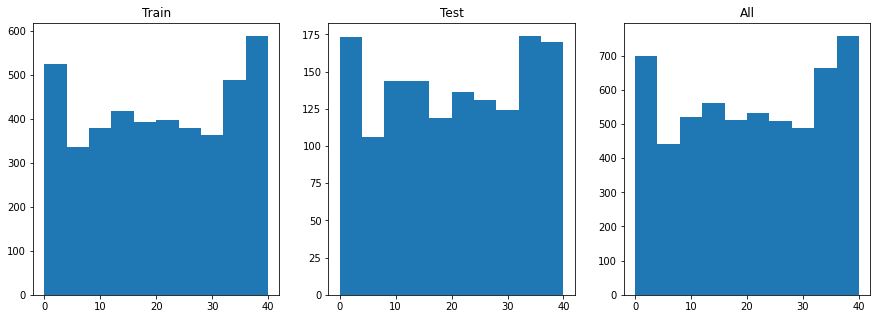

In [210]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 5))
ax[0].hist(train_markup.int_label)
ax[0].set_title("Train")

ax[1].hist(test_markup.int_label)
ax[1].set_title("Test");

ax[2].hist(markup.int_label)
ax[2].set_title("All");

## Загрузка или формирование фич

## Чтение файла

In [211]:
def read_from_zip(zip_store, filename):
    with io.BytesIO() as bytes_buff:
        bytes_data = zip_store.read(filename)
        bytes_buff.write(bytes_data)
        bytes_buff.seek(0)
        wave, sr = torchaudio.load(bytes_buff)
    return sr, wave

## Vad

In [212]:
def simple_vad(wav, sr):
  amp2db = torchaudio.transforms.AmplitudeToDB()
  wav = amp2db(wav)
  melSpec = torchaudio.transforms.MelSpectrogram(sr, n_fft=25 * sr//1000,\
                                                    hop_length = 10 * sr//1000,\
                                                    n_mels=80, 
                                                    norm="slaney", 
                                                    window_fn = torch.hamming_window)
  spec = torch.log(melSpec(wav))
  max_amp = torch.argmax(torch.max(spec[0], 1).values)
  target_bin = torch.argmax(spec[0, :, max_amp])
  win_lengh = 50 if spec.shape[-1]//2 > 50 else spec.shape[-1]//2
  threshing = torch.nn.functional.conv1d(spec[0, target_bin][None, None, :], 
                                         torch.hann_window(win_lengh)[None, None, :], 
                                         padding="same")
  thresholding = torch.zeros_like(threshing[0, 0])
  threshold = torch.mean(threshing[0, 0])
  thresholding[threshing[0, 0] > threshold] = 1

  split_spec = spec[0,:, thresholding == 1]
  split_spec = split_spec
  return split_spec, thresholding

## Ресерч фичей и simple VAD

In [213]:
def get_next():
  for idx, row in markup.groupby("label").first().iterrows():
    yield row
this_row_it = iter(get_next())

In [14]:
row = next(this_row_it)

In [15]:
sr, wav = read_from_zip(dataset, f"train/{row.fname}")

display(Audio((wav[0]), rate=sr))

In [19]:

melSpec = torchaudio.transforms.MelSpectrogram(sr, n_fft=25 * sr//1000,\
                                                   hop_length = 10 * sr//1000,\
                                                   n_mels=80, 
                                                   norm="slaney", 
                                                   window_fn = torch.hamming_window)
spec = melSpec(wav)
librosa.display.specshow(spec.numpy()[0], sr=sr, hop_length=10 * sr//1000,
                         x_axis='time', ax=ax)

(tensor(6), tensor(7))

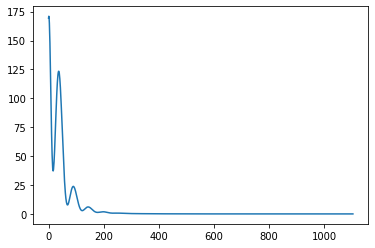

In [20]:
max_amp = torch.argmax(torch.max(spec[0], 1).values)
target_bin = torch.argmax(spec[0, :,  max_amp])
threshing = torch.nn.functional.conv1d(spec[:, target_bin][:, None, :], torch.hann_window(30)[None, None, :])

plt.plot(threshing.numpy()[0, 0]);
target_bin, max_amp

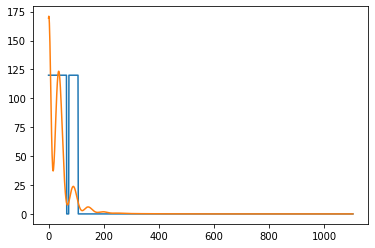

In [24]:
thresholding = torch.zeros_like(threshing[0, 0])
thresholding[threshing[0, 0] > 10] = 1
plt.plot(thresholding.numpy() * 120)
plt.plot(threshing.numpy()[0, 0])

In [25]:
end = -1

In [26]:
start = torch.argmax(thresholding[end+1:])
start += end+1
max = torch.max(thresholding[end+1:])
end = torch.argmin(thresholding[start:])
min = torch.min(thresholding[start:])
end += start 
start -= 1

# print(end, start)
# if end - start > 1:
start_it = int(start / 100 * sr) if start >= 0 else 0
end_it = int(end / 100 * sr)
print(start_it, end_it)
print(start, end)
display(Audio((wav[0, start_it:-1]), rate=sr))
# else:
#   print("It's all")

0 10560
tensor(-1) tensor(66)


### Test VAD

In [ ]:
res, tr = simple_vad(wav, sr)
plt.plot(tr.numpy());

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
librosa.display.specshow(res.numpy(), sr=sr, hop_length=10 * sr//1000,
                         x_axis='time', ax=ax)

# Майнинг фичей

In [214]:
%%time
if not FEATS.exists():
  feats = dict()
  for idx, mark in tqdm(markup.iterrows()):
    sr, wav = read_from_zip(dataset, f"train/{mark.fname}")
    my_feats = simple_vad(wav, sr)

    feats[mark.fname] = my_feats 
  with open(FEATS, "wb") as f:
    pickle.dump(feats, f)
else:
  with open(FEATS, "rb") as f:
    feats = pickle.load(f)

CPU times: user 2.58 s, sys: 1.83 s, total: 4.4 s
Wall time: 5.63 s


# Обучение SVM

In [200]:
def get_features(features, win_lengh=100, hop_length=50, agr_hop=20):
  feat_list = []
  steps = features.shape[-1] // hop_length
  n_feats = features.shape[0]
  if steps == 0:
    return []
  for step in range(steps):
    start = step * hop_length
    end = start + win_lengh
    if end > features.shape[-1]:
      continue
    else:
      tmp = features[:, start:end].numpy()
      agr_steps = win_lengh // agr_hop
      agr_feats = []
      for agr_step in range(agr_steps):
        agr_feats.append(np.max(tmp[:, agr_step*agr_hop : (agr_step+1)*agr_hop], axis=1))
      agr_feats = np.array(agr_feats)
    feat_list.append(np.concatenate((np.mean(agr_feats, axis=0), 
                                     np.median(agr_feats, axis=0))))
  return feat_list

In [215]:
%%time
x_train = []
y_train = []

x_test = []
y_test = []

for idx, val in tqdm(train_markup.iterrows()):
  if feats[val.fname][0].shape[-1] == 0:
    continue
  a = torch.nanmean(feats[val.fname][0], dim=1)
  b = torch.nanmedian(feats[val.fname][0], dim=1).values
  x_train.append(torch.cat((a, b)).numpy())
  # feat = get_features(feats[val.fname][0])
  # labels = [val.int_label] * len(feat)
  # x_train = x_train + feat
  # y_train = y_train + labels
  y_train.append(val.int_label)

# missing = 0
# dict_compiration = dict()
# start = 0
for idx, val in tqdm(test_markup.iterrows()):
  if feats[val.fname][0].shape[-1] == 0:
    continue
  a = torch.nanmean(feats[val.fname][0], dim=1)
  b = torch.nanmedian(feats[val.fname][0], dim=1).values
  x_test.append(torch.cat((a, b)).numpy())
  # feat = get_features(feats[val.fname][0])
  # labels = [val.int_label] * len(feat)
  # x_test = x_test + feat
  # y_test = y_test + labels
  # end = start + len(feat)
  # if start == end:
  #   missing += 1
  # dict_compiration[val.fname] = {"bound":[start, end], "int_label":val.int_label}
  # start = end
  y_test.append(val.int_label)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

CPU times: user 8.02 s, sys: 96.2 ms, total: 8.11 s
Wall time: 8.14 s


In [216]:
%%time
from sklearn.decomposition import FastICA

decompose = FastICA(20)
X_train = decompose.fit_transform(np.array(x_train))
X_test = decompose.transform(np.array(x_test))

CPU times: user 559 ms, sys: 554 ms, total: 1.11 s
Wall time: 658 ms


In [217]:
with open(Path("/content/drive/My Drive/EventDetection/ICA20_mean_median_data.pickle"), "wb") as f:
  pickle.dump([X_train, y_train, X_test, y_test], f)

with open(Path("/content/drive/My Drive/EventDetection/ICA20_mean_median.pickle"), "wb") as f:
  pickle.dump(decompose, f)

In [218]:
%%time
SVM = SVC(probability=True, random_state=27)
SVM.fit(X_train, y_train)

with open(Path("/content/drive/My Drive/EventDetection/SVC_ICA_20_mean_median.pickle"), "wb") as f:
  pickle.dump(SVM, f)

CPU times: user 7.49 s, sys: 9.02 ms, total: 7.5 s
Wall time: 7.48 s


In [219]:
y_pred = SVM.predict(X_test)

In [220]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.25      0.48      0.33        44
         1.0       0.60      0.74      0.66        46
         2.0       0.31      0.38      0.34        40
         3.0       0.36      0.58      0.45        43
         4.0       0.69      0.47      0.56        19
         5.0       0.14      0.07      0.10        14
         6.0       0.44      0.29      0.35        51
         7.0       0.00      0.00      0.00        22
         8.0       0.48      0.55      0.51        51
         9.0       0.00      0.00      0.00        20
        10.0       0.23      0.17      0.20        40
        11.0       0.78      0.76      0.77        33
        12.0       0.58      0.29      0.38        52
        13.0       0.00      0.00      0.00        21
        14.0       0.00      0.00      0.00        26
        15.0       0.31      0.44      0.36        45
        16.0       0.52      0.68      0.59        19
        17.0       0.19    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# All_results:
* Slingin window 100-win_len, 50-hop_len, 20 - inter_win_hop + ICA : ACC = 0.35, F1 = 0.33
* Slingin window 100-win_len, 50-hop_len, 20 - inter_win_hop + ICA + agrigation: ACC = 0.34, F1 = 0.33
* Sliding feats with 1000 ms window, 800ms hop, and 20 inter_window hop: ACC = 0.31, F1 =0.28
* ICA(cancat(Mean, Median)): ACC = 0.36, F1 = 0.34
* KernelPCA(cancat(Mean, Median)) kernel = rbf; ACC = 0.33, F1 = 0.31
*  PCA(cancat(Mean, Median)); ACC = 0.32, F1 = 0.29
* VAD(raw data).mean ACC = 0.31, F1 = 0.28
* (raw data).mean ACC 0.09, F1 = 0.07

# Slingin window 100-win_len, 50-hop_len, 20 - inter_win_hop + ICA

In [97]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.43      0.72      0.54       470
         1.0       0.68      0.75      0.71       880
         2.0       0.29      0.42      0.34       569
         3.0       0.07      0.05      0.06       165
         4.0       0.70      0.23      0.34        93
         5.0       0.33      0.57      0.42       287
         6.0       0.41      0.34      0.37       538
         7.0       0.51      0.27      0.35       480
         8.0       0.50      0.65      0.56       532
         9.0       0.23      0.08      0.12       357
        10.0       0.19      0.15      0.17       226
        11.0       0.55      0.28      0.37       116
        12.0       0.47      0.29      0.35       189
        13.0       0.07      0.02      0.03       214
        14.0       0.23      0.03      0.05       356
        15.0       0.11      0.04      0.06       252
        16.0       0.53      0.61      0.57        41
        17.0       0.32    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Slingin window 100-win_len, 50-hop_len, 20 - inter_win_hop + ICA + agrigation

In [109]:
import scipy.stats
def mark_compiration(dict_compiration, y_pred):
  y_real_pred = []
  y_true = []
  miss_counter = 0
  for _, val in dict_compiration.items():
    if val["bound"][0] == val["bound"][1]:
      miss_counter += 1
      continue
    # mode = scipy.stats.mode(y_pred[val["bound"][0]:
    #                                val["bound"][1]])[0]
    # if not mode:
    mode = np.median(y_pred[val["bound"][0]:
                              val["bound"][1]])
    y_real_pred.append(int(mode))
    y_true.append(int(val["int_label"]))
  return y_real_pred, y_true, miss_counter
y_pred_, y_true_, miss = mark_compiration(dict_compiration, y_pred)

In [110]:
print(classification_report(y_true_, y_pred_));

              precision    recall  f1-score   support

           0       0.44      0.56      0.49        41
           1       0.68      0.85      0.76        46
           2       0.38      0.53      0.44        34
           3       0.08      0.07      0.07        15
           4       0.71      0.42      0.53        12
           5       0.17      0.46      0.25        13
           6       0.50      0.45      0.47        51
           7       0.47      0.41      0.44        22
           8       0.46      0.71      0.56        51
           9       0.29      0.21      0.24        19
          10       0.29      0.16      0.21        25
          11       0.62      0.56      0.59        27
          12       0.54      0.30      0.39        46
          13       0.00      0.00      0.00        19
          14       0.09      0.05      0.06        22
          15       0.33      0.06      0.10        36
          16       0.75      0.38      0.50         8
          17       0.27    

# Sliding feats with 1000 ms window, 800ms hop, and 20 inter_window hop

In [21]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.36      0.69      0.47       301
         1.0       0.60      0.75      0.66       559
         2.0       0.30      0.43      0.35       366
         3.0       0.07      0.02      0.03       109
         4.0       0.67      0.07      0.12        60
         5.0       0.30      0.47      0.36       182
         6.0       0.39      0.34      0.36       342
         7.0       0.40      0.15      0.22       303
         8.0       0.60      0.49      0.54       344
         9.0       0.08      0.01      0.02       227
        10.0       0.16      0.05      0.07       147
        11.0       1.00      0.26      0.41        74
        12.0       0.44      0.16      0.23       127
        13.0       0.15      0.01      0.03       137
        14.0       0.47      0.03      0.06       225
        15.0       0.11      0.01      0.02       166
        16.0       0.78      0.23      0.36        30
        17.0       0.22    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Independent component analysis

In [65]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.25      0.48      0.33        44
         1.0       0.60      0.74      0.66        46
         2.0       0.31      0.38      0.34        40
         3.0       0.36      0.58      0.45        43
         4.0       0.69      0.47      0.56        19
         5.0       0.14      0.07      0.10        14
         6.0       0.44      0.29      0.35        51
         7.0       0.00      0.00      0.00        22
         8.0       0.48      0.55      0.51        51
         9.0       0.00      0.00      0.00        20
        10.0       0.23      0.17      0.20        40
        11.0       0.78      0.76      0.77        33
        12.0       0.58      0.29      0.38        52
        13.0       0.00      0.00      0.00        21
        14.0       0.00      0.00      0.00        26
        15.0       0.31      0.44      0.36        45
        16.0       0.52      0.68      0.59        19
        17.0       0.19    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Kernal PCA RBF 

In [54]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.33      0.32      0.32        44
         1.0       0.62      0.74      0.67        46
         2.0       0.35      0.42      0.38        40
         3.0       0.46      0.51      0.48        43
         4.0       0.50      0.53      0.51        19
         5.0       0.17      0.14      0.15        14
         6.0       0.31      0.25      0.28        51
         7.0       0.67      0.09      0.16        22
         8.0       0.28      0.69      0.40        51
         9.0       0.00      0.00      0.00        20
        10.0       0.31      0.45      0.37        40
        11.0       0.69      0.61      0.65        33
        12.0       0.35      0.50      0.41        52
        13.0       0.06      0.05      0.05        21
        14.0       0.00      0.00      0.00        26
        15.0       0.39      0.51      0.44        45
        16.0       0.31      0.21      0.25        19
        17.0       0.24    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# PCA Mean + Median

In [46]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.20      0.18      0.19        44
         1.0       0.45      0.78      0.57        46
         2.0       0.30      0.30      0.30        40
         3.0       0.36      0.49      0.41        43
         4.0       0.58      0.37      0.45        19
         5.0       0.00      0.00      0.00        14
         6.0       0.25      0.27      0.26        51
         7.0       0.00      0.00      0.00        22
         8.0       0.49      0.51      0.50        51
         9.0       0.00      0.00      0.00        20
        10.0       0.22      0.28      0.24        40
        11.0       0.42      0.76      0.54        33
        12.0       0.29      0.52      0.37        52
        13.0       0.00      0.00      0.00        21
        14.0       0.00      0.00      0.00        26
        15.0       0.32      0.58      0.41        45
        16.0       0.00      0.00      0.00        19
        17.0       0.18    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Mean + Median vector

In [31]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.23      0.32      0.26        44
         1.0       0.47      0.80      0.60        46
         2.0       0.30      0.28      0.29        40
         3.0       0.38      0.49      0.43        43
         4.0       0.89      0.42      0.57        19
         5.0       0.00      0.00      0.00        14
         6.0       0.32      0.24      0.27        51
         7.0       0.00      0.00      0.00        22
         8.0       0.49      0.53      0.51        51
         9.0       0.00      0.00      0.00        20
        10.0       0.23      0.23      0.23        40
        11.0       0.39      0.79      0.53        33
        12.0       0.27      0.44      0.33        52
        13.0       0.00      0.00      0.00        21
        14.0       0.00      0.00      0.00        26
        15.0       0.30      0.56      0.39        45
        16.0       0.38      0.16      0.22        19
        17.0       0.16    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Вот так Vad + log

In [612]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.21      0.32      0.25        44
         1.0       0.46      0.78      0.58        46
         2.0       0.33      0.30      0.32        40
         3.0       0.35      0.47      0.40        43
         4.0       0.67      0.42      0.52        19
         5.0       0.00      0.00      0.00        14
         6.0       0.28      0.24      0.26        51
         7.0       0.00      0.00      0.00        22
         8.0       0.52      0.49      0.51        51
         9.0       0.00      0.00      0.00        20
        10.0       0.21      0.20      0.20        40
        11.0       0.46      0.76      0.57        33
        12.0       0.27      0.48      0.34        52
        13.0       0.00      0.00      0.00        21
        14.0       0.00      0.00      0.00        26
        15.0       0.27      0.56      0.37        45
        16.0       0.36      0.42      0.39        19
        17.0       0.17    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Такое было без vad и логорифмирования

In [10]:
print(classification_report(y_test, y_pred));

              precision    recall  f1-score   support

         0.0       0.19      0.16      0.17        44
         1.0       0.11      0.11      0.11        46
         2.0       0.40      0.05      0.09        40
         3.0       0.43      0.60      0.50        43
         4.0       0.00      0.00      0.00        19
         5.0       0.00      0.00      0.00        14
         6.0       0.45      0.10      0.16        51
         7.0       0.00      0.00      0.00        22
         8.0       0.00      0.00      0.00        51
         9.0       0.00      0.00      0.00        20
        10.0       0.00      0.00      0.00        40
        11.0       0.00      0.00      0.00        33
        12.0       0.48      0.23      0.31        52
        13.0       0.00      0.00      0.00        21
        14.0       0.00      0.00      0.00        26
        15.0       0.15      0.16      0.15        45
        16.0       0.00      0.00      0.00        19
        17.0       0.20    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
